# 深圳签订外贸合同量预测ARIMA模型

## 使用到的模块及其安装

 - Python version: 3.11.0

 - Pandas version: 2.2.3
    - pip install pandas==2.2.3

 - NumPy version: 2.2.2
    - pip install numpy==2.2.2

 - tqdm version: 4.67.1
    - pip install tqdm==4.67.1

 - Matplotlib version: 3.10.1
    - pip install matplotlib==3.10.1

 - Statsmodels version:
    - pip install statsmodels==0.14.4

 - SciKit-Learn version: 1.6.1
    - pip install scikit-learn==1.6.1

In [361]:
from datetime import datetime

import pandas as pd
import numpy as np
from tqdm import trange, tqdm

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import warnings
warnings.simplefilter('ignore', category=UserWarning)

from sklearn.metrics import mean_squared_error

import matplotlib as mpl
mpl.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False
import matplotlib.pyplot as plt
%matplotlib inline

In [362]:
df=pd.read_excel('深圳签订外贸合同项数数据1990~2023.xlsx')

# 获取全部的列名列表
# all_columns = df.columns.tolist()
# print(all_columns)

# 输入一个需要预测的国家或地区
"""
    '中国香港、澳门', '中国台湾', '新加坡', '韩国', '日本', 
    '泰国', '澳大利亚', '马来西亚', '美国', '加拿大', 
    '德国', '法国', '英国', '瑞士', '荷兰', '其他'
"""
# need_to_predict = str(input("请输入您需要预测的国家："))
need_to_predict = "中国香港、澳门"
# print(need_to_predict)
# years_to_predicted = int(input("请输出需要预测未来多少年的数据"))
years_to_predicted = 20
# print(f"预测未来{years_to_predicted}年内{need_to_predict}的数据")

# 保留单一列数据，用于预测。这里以用户指定的国家/地区为例（'中国香港、澳门'）。
df_total = df[['时间', need_to_predict]].copy()

print('原数据预览：\n', df.head())
print('保留后数据预览：\n', df_total.head())

原数据预览：
      时间  中国香港、澳门  中国台湾  新加坡  韩国  日本  泰国  澳大利亚  马来西亚   美国  加拿大  德国  法国  英国  瑞士  \
0  1990      699    45    5   0  12   2     2     1   16    2   0   1   2   3   
1  1991      885    36    8   3  17   3     1     0   18    2   2   3   2   1   
2  1992     1330    88   20   5  16   8     6     3   57    8   1   2   5   0   
3  1993     2834   154   24   8  27  15    14     5  104   22   2   4  16   2   
4  1994     1885   124   29   8  25   8     7     3   74   10   5   3  19   0   

   荷兰  其他  
0   0   6  
1   1   4  
2   1  11  
3   3  23  
4   1  22  
保留后数据预览：
      时间  中国香港、澳门
0  1990      699
1  1991      885
2  1992     1330
3  1993     2834
4  1994     1885


## 进出口总额预测处理

In [363]:
# 修改列标题
df_total.columns = ["日期", need_to_predict]
# 转化时间数据为 datetime 对象
df_total['日期'] = pd.to_datetime(df_total['日期'], format='%Y')

# 设置时间索引
df_total.set_index('日期', inplace=True)
df_total.head()

,中国香港、澳门
日期,
1990-01-01,699
1991-01-01,885
1992-01-01,1330
1993-01-01,2834
1994-01-01,1885


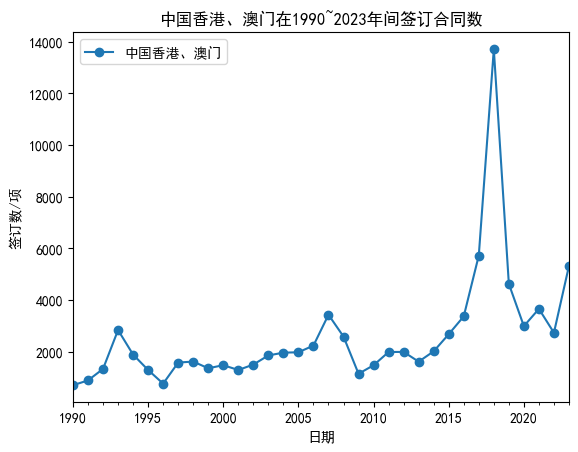

In [364]:
# 原始数据可视化绘图
df_total.plot(kind='line', marker='o')
plt.title(f"{need_to_predict}在1990~2023年间签订合同数")
plt.ylabel('签订数/项')
plt.show()

### 划分训练、测试集
#### 使用 60% 内容用于训练，40% 用于测试

In [365]:
X = df_total.values
size = int(len(X) * 0.60)
train, test = X[0:size], X[size:len(X)]

# 输出划分后的训练集和测试集
# print("训练集：")
# print(train)
# print("\n测试集：")
# print(test)

# 初始化历史数据列表，用于存储训练集中的数据
history = [x for x in train]

In [366]:
def find_best_arima_params(train_data, max_p=5, max_d=2, max_q=5):
    best_aic = float("inf")
    best_bic = float("inf")
    best_order = None
    
    for p in trange(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore', category=UserWarning)
                    try:
                        model = ARIMA(train_data, order=(p, d, q))
                        model_fit = model.fit()
                        current_aic = model_fit.aic
                        current_bic = model_fit.bic
                        
                        # 同时更新AIC和BIC的最低值
                        if current_aic < best_aic:
                            best_aic = current_aic
                            best_order = (p, d, q)
                        if current_bic < best_bic:
                            best_bic = current_bic
                            best_order = (p, d, q)
                        # print(f"order = ({p, d, q})", end="\t")
                        # print(f'AIC: {current_aic}\tBIC: {current_bic}')
                    except:
                        continue
    
    # 返回最终选中的order及其对应的AIC/BIC
    return best_order, best_aic, best_bic

best_order, aic, bic = find_best_arima_params(train)
print(f'Best ARIMA order: {best_order}')
print(f'AIC: {aic}, BIC: {bic}')

100%|██████████| 6/6 [00:10<00:00,  1.81s/it]

Best ARIMA order: (0, 2, 4)
AIC: 293.58347675110485, BIC: 296.16032517997763


In [367]:
# 初始化预测结果列表
predictions = list()
# 对测试集中的每个时间点进行预测
print("当前最佳ARIMA参数：",best_order)
for t in trange(len(test)):
    # 使用历史数据拟合 ARIMA 模型
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=UserWarning)
        try:
            model = ARIMA(history, order=best_order)
            model_fit = model.fit()
            output = model_fit.forecast()
            yhat = output[0]
            predictions.append(yhat)
            obs = test[t]
            history.append(obs)
            # print(f'预测值：{yhat:.0f}\t实际观测值：{obs[0]}')
        except:
            continue

# 计算预测结果的均方误差（MSE）
error = mean_squared_error(test, predictions)
print(f'实际值与预测值之间的均方误差 (MSE): {error:.3f}')

当前最佳ARIMA参数： (0, 2, 4)


100%|██████████| 14/14 [00:01<00:00,  9.55it/s]

实际值与预测值之间的均方误差 (MSE): 37182609.966


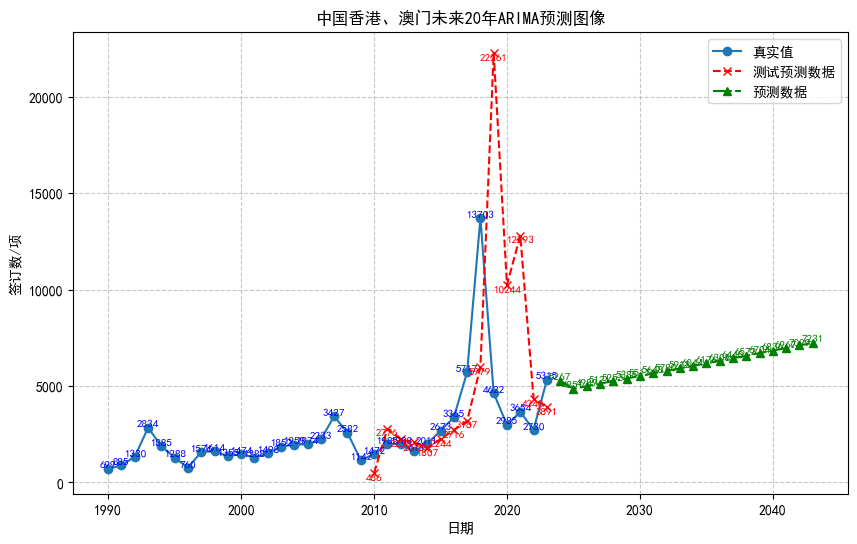

In [368]:
# 绘制预测图像

model = ARIMA(X, order=best_order)
model_fit = model.fit()
future_forecast = model_fit.forecast(steps=years_to_predicted)

# 创建未来年份的索引
last_year = df_total.index[-1].year
future_years = [datetime(year=last_year + i + 1, month=1, day=1) for i in range(years_to_predicted)]

# 绘制实际值、测试集预测值和未来预测值的对比图
plt.figure(figsize=(10, 6))  # 设置图像大小
plt.plot(df_total.index, X, label='真实值', marker='o')  # 绘制实际值曲线
plt.plot(df_total.index[size:], predictions, color='red', label='测试预测数据', linestyle='--', marker='x')  # 绘制测试集预测值曲线
plt.plot(future_years, future_forecast, color='green', label='预测数据', linestyle='-.', marker='^')  # 绘制未来预测值曲线
plt.legend()  # 添加图例
plt.title(f'{need_to_predict}未来{years_to_predicted}年ARIMA预测图像')  # 添加标题
plt.xlabel('日期')  # 添加X轴标签
plt.ylabel('签订数/项')  # 添加Y轴标签
plt.grid(True, linestyle='--', alpha=0.7)  # 添加网格线

# 在每个数据点上显示数值
for i, value in enumerate(X):
    value = value[0]
    plt.text(df_total.index[i], value, f'{value:.0f}', ha='center', va='bottom', fontsize=8, color='blue')

for i, value in enumerate(predictions):
    plt.text(df_total.index[size:][i], value, f'{value:.0f}', ha='center', va='top', fontsize=8, color='red')

for i, value in enumerate(future_forecast):
    plt.text(future_years[i], value, f'{value:.0f}', ha='center', va='bottom', fontsize=8, color='green')

# plt.show()  # 显示图像
plt.savefig(f"out_file/out_fig/{need_to_predict}的未来{years_to_predicted}年合同签订项预测图像.png")

ADF检验结果：
ADF检验统计量 : -3.1721600862949275
p值 : 0.021653784006136444
使用的滞后数 : 0
使用的观测值数量 : 33
反对原假设(H0)的有力证据，否定原假设。数据没有单位根，并且是平稳的。

ADF检验结果：
ADF检验统计量 : -2.189309137507035
p值 : 0.2101484792936203
使用的滞后数 : 10
使用的观测值数量 : 21
反对零假设的弱证据，时间序列有一个单位根，表明它是非平稳的。



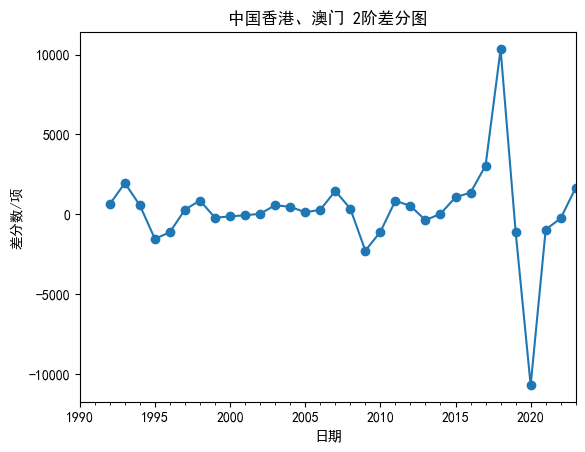

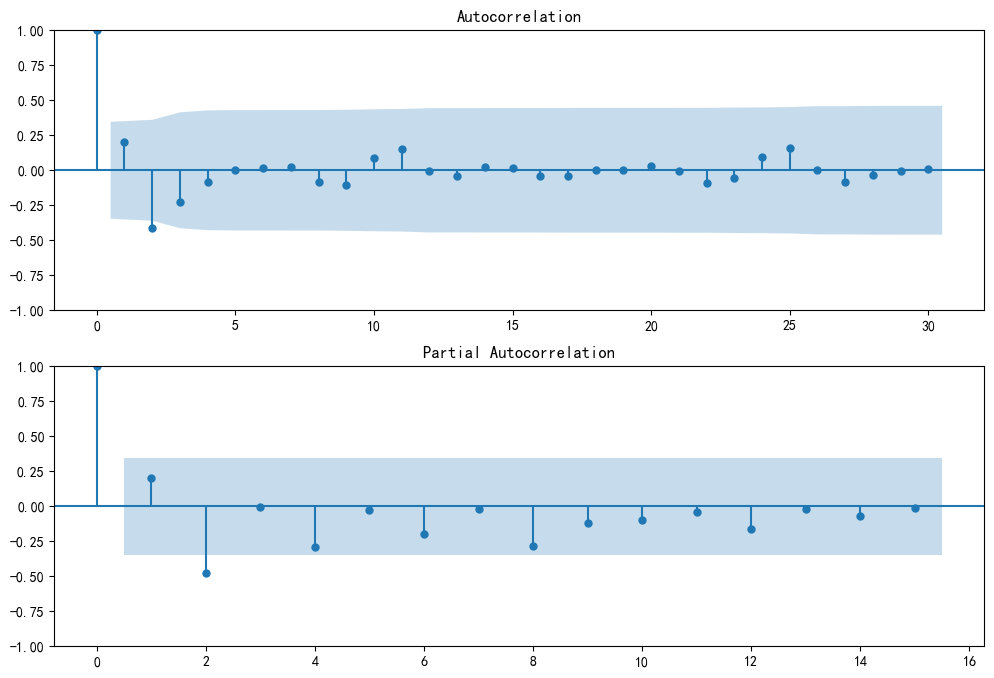

In [369]:
# ADF 检验函数
# H0：它是非平稳的  
# H1：它是平稳的
def adfuller_test(sales, title=""):
    result = adfuller(sales)
    labels = ['ADF检验统计量', 'p值', '使用的滞后数', '使用的观测值数量']
    print(f"{title}ADF检验结果：")
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    if result[1] <= 0.05:
        print("反对原假设(H0)的有力证据，否定原假设。数据没有单位根，并且是平稳的。\n")
    else:
        print("反对零假设的弱证据，时间序列有一个单位根，表明它是非平稳的。\n")

d = best_order[1]  # 获取最佳ARIMA参数中的差分阶数

# ADF 检验1：原始数据平稳性检验
adfuller_test(df_total[need_to_predict])

df_total[f'{d}阶差分'] = df_total[need_to_predict] - df_total[need_to_predict].shift(d)

# ADF 检验2：经过d阶差分后的数据平稳性检验
adfuller_test(df_total[f'{d}阶差分'].dropna())

# 绘制可视化图像
df_total[f'{d}阶差分'].plot(kind='line', marker='o')
plt.title(f"{need_to_predict} {d}阶差分图")
plt.ylabel('差分数/项')
plt.show()

# 绘制自相关函数（ACF）图和偏自相关函数（PACF）图
fig1 = plt.figure(figsize=(12, 8))
ax1 = fig1.add_subplot(211)
fig1 = plot_acf(df_total[f'{d}阶差分'].dropna(), lags=30, ax=ax1)  # 绘制自相关函数（ACF）图
ax2 = fig1.add_subplot(212)
fig1 = plot_pacf(df_total[f'{d}阶差分'].dropna(), lags=15, ax=ax2)  # 偏自相关函数（PACF）图
plt.show()

In [370]:
# 保存文件
last_year = df_total.index[-1].year
future_years = [datetime(year=last_year + i + 1, month=1, day=1) for i in range(years_to_predicted)]

# 创建包含预测年份和预测数据的DataFrame
future_df = pd.DataFrame({
    '日期': future_years,
    f'{need_to_predict}预测数据（项）': future_forecast.round().astype(int)
})

# 保存到Excel文件
future_df.to_excel(f'out_file/out_excel/{need_to_predict}的未来{years_to_predicted}年合同签订项数量预测.xlsx', index=False)
